In [64]:
# import modules
import torch
import torchOptics.optics as tt
import torchOptics.models as tm
import torchOptics.binary as tb
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import warnings
warnings.filterwarnings('ignore')

folder = '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/' # define dataset folder
device = 'cuda' # define device
z = 2e-3 # propagation distance
meta = {'dx':[6.3e-6, 6.3e-6], 'wl':[515e-9]} # pixel pitch

binary_num = 10
px = 4
net = tm.ShuffleResnet(in_channels=[1*px**2]+[128 for _ in range(20)]+[binary_num*px**2], activations='LeakyReLU', last_layer_args=[-1,1], pixel_shuffle=px).to(device)
dataset = tt.MultiImageDatasetImageio(folder, transform=transforms.Compose([transforms.ToTensor(), 
                                                                            transforms.Grayscale(), 
                                                                            transforms.RandomCrop((1024,1024), pad_if_needed=True)]))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
dataloader = DataLoader(dataset, batch_size=1, num_workers=6)

loss_history = []
net.train()
for epoch in range(100):
    pbar = tqdm.tqdm(dataloader)
    for data in pbar:
        optimizer.zero_grad()
        x = data[0].to(device)
        output = tt.Tensor(tb.threshold(net(x)), meta=meta)
        field = output.reshape(-1, len(meta['wl']), output.shape[-2], output.shape[-1])
        sim = (tt.simulate(field, -z).abs()**2)
        sim = torch.mean(sim.reshape(-1, binary_num, len(meta['wl']), output.shape[-2], output.shape[-1]), dim=1)
        loss = tt.relativeLoss(sim, x, F.mse_loss)
        loss.backward()
        optimizer.step()
        pbar.set_description('{:.4f}'.format(loss.item()))
        loss_history.append(loss.item())

    # if epoch==0:
    #     net.eval()
    #     net._clear_train()
    #     net.train()

0.0030: 100%|██████████| 800/800 [01:07<00:00, 11.92it/s]


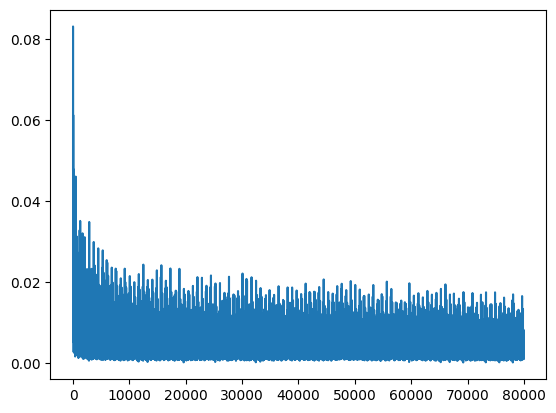

In [65]:
plt.plot(loss_history)


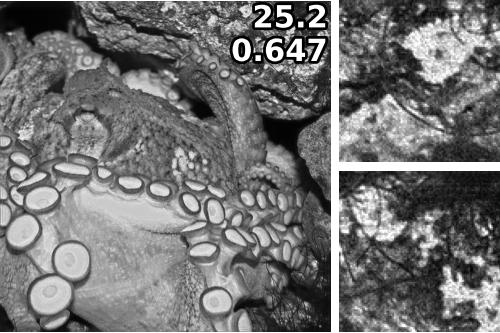
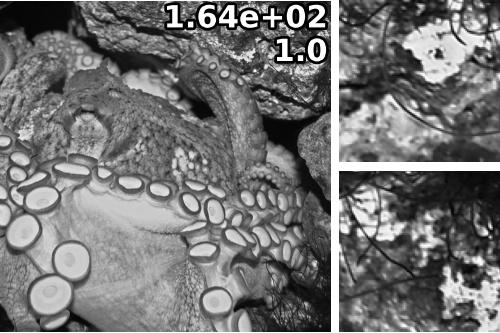

In [66]:
tt.show_with_insets(sim, x)
tt.show_with_insets(x, x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



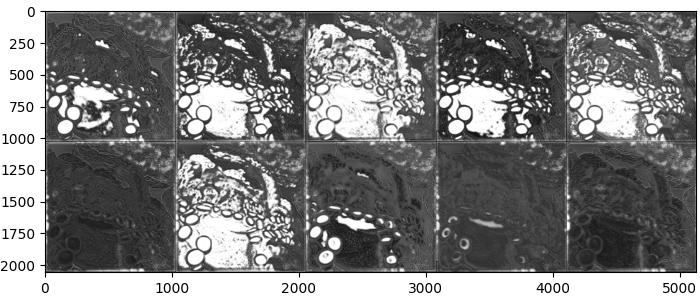
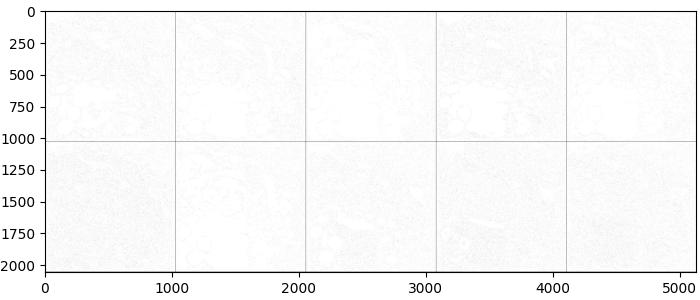
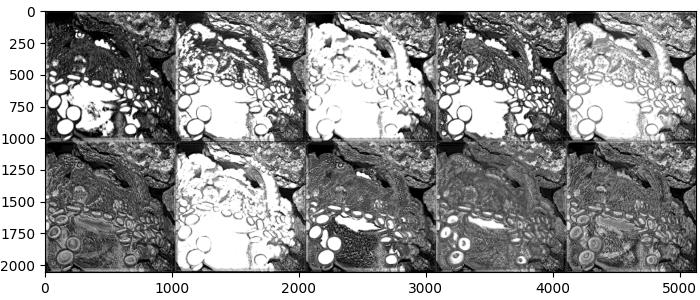
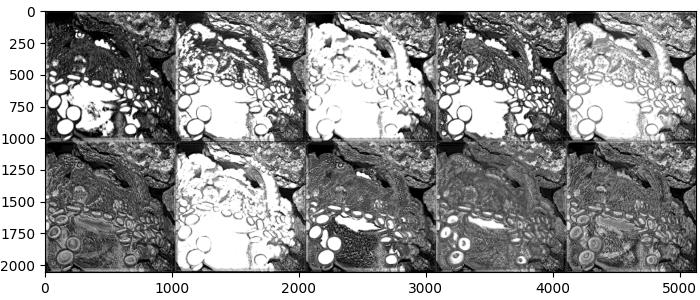

In [67]:
tt.show(net(x), figsize=(7,3))
tt.show(net(x)*100, figsize=(7,3))
tt.show(tb.threshold(net(x)), figsize=(7,3))
tt.show(tb.threshold(F.hardtanh(net(x))), figsize=(7,3))